In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [2]:
df = pd.read_csv(r'OpTransactionHistory27-11-2022.csv')

In [3]:
df["Month"] = df.apply(lambda row: pd.to_datetime(
    row['Transaction Date']).month, axis=1)
df['Withdrawals'] = df['Withdrawals'].str.replace(',', '')
df['Deposits'] = df['Deposits'].str.replace(',', '')
df = df.astype({"Withdrawals":'float',"Deposits":'float'})

In [4]:
outliers = df[(df['Withdrawals'] >=10000) | (df['Deposits'] >= 10000)]
df.drop(outliers.index , inplace=True)
outliers.head(15)

,SlNo,Transaction Date,Value Date,Particulars,Unnamed: 4,Unnamed: 5,Cheque Number,Withdrawals,Deposits,Balance Amount,Month
2,3.0,18-Jun-2022,18-Jun-2022,BY CASH BR:BIDADI/CCEPN8833J,NaN,NaN,NaN,NaN,100000.0,"1,00,010.25",6.0
3,4.0,18-Jun-2022,18-Jun-2022,NEFT:KING HYDROPONICS/,NaN,NaN,NaN,NaN,26500.0,"1,26,510.25",6.0
284,285.0,26-Sep-2022,26-Sep-2022,Dr. Tran for funding A/c ZZ37342506/,NaN,NaN,NaN,100000.0,NaN,"6,476.07",9.0


In [5]:
monthly = df.groupby('Month').sum()
month_withdrawal = df.groupby('Month')['Withdrawals'].sum()
print(monthly)
month_deposit = df.groupby('Month')['Deposits'].sum()

          SlNo  Unnamed: 4  Cheque Number  Withdrawals  Deposits
Month                                                           
6.0      293.0         0.0            0.0      3443.50    2506.0
7.0     4453.0         0.0            0.0     10977.28    7182.0
8.0    14357.0         0.0            0.0      8631.30    1597.0
9.0    25755.0         0.0            0.0     13724.00    1707.0
10.0   34251.0         0.0            0.0      9444.00    7953.0
11.0   28015.0         0.0            0.0     10933.34   10573.5


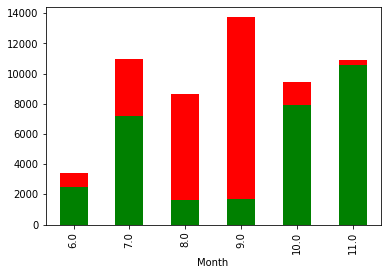

In [6]:
month_withdrawal.plot(x='month', y='withdraw', kind='bar', label='withdraw', color='red')
month_deposit.plot(x='month',y='deposit',kind='bar',label='deposit',color='green')

In [7]:
monthly["Expenditure"]=monthly.apply(lambda row: row["Withdrawals"] - row["Deposits"],axis=1)
months=monthly.index.tolist()

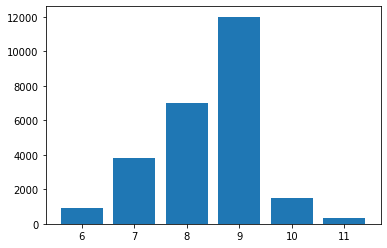

In [8]:
plt.bar(monthly.index,monthly["Expenditure"])
plt.show()

In [9]:
df = df[df['Particulars'].notna()]
df[df['Particulars'].str.contains("Ranjith | LAVANYA G")]["Withdrawals"].sum()
#indexAge = df[ (df['Particulars'].str.contains("Ranjith"))]
#indexAge.sum()

80.0

In [10]:
df.head(10)

,SlNo,Transaction Date,Value Date,Particulars,Unnamed: 4,Unnamed: 5,Cheque Number,Withdrawals,Deposits,Balance Amount,Month
0,1.0,18-Jun-2022,18-Jun-2022,UPI/SBIN/216910094455/SREELEKHA S/UPI/SBIce0b...,NaN,NaN,NaN,NaN,1000.0,"1,010.25",6.0
1,2.0,18-Jun-2022,18-Jun-2022,UPI/SBIN/216990141498/SUNITHA NORONHA/UPI/ICI...,NaN,NaN,NaN,1000.0,NaN,10.25,6.0
4,5.0,21-Jun-2022,21-Jun-2022,UPI/YESB/217251515787/Nandini/UPI/ICIebaf445c2...,NaN,NaN,NaN,185.0,NaN,"1,26,325.25",6.0
5,6.0,21-Jun-2022,21-Jun-2022,UPI/UTIB/217217319053/CHANDRASHEKAR T E/UPI/IC...,NaN,NaN,NaN,300.0,NaN,"1,26,025.25",6.0
6,7.0,21-Jun-2022,21-Jun-2022,UPI/KKBK/217299623992/JOHN B NORONHA/UPI/ICIe1...,NaN,NaN,NaN,NaN,1500.0,"1,27,525.25",6.0
7,8.0,21-Jun-2022,21-Jun-2022,UPI/PYTM/217202526606/MEDPLUS KENGERI UPANAGAR...,NaN,NaN,NaN,291.5,NaN,"1,27,233.75",6.0
8,9.0,22-Jun-2022,22-Jun-2022,UPI/IDIB/217380940384/Mr SABI VIJI/UPI/ICIe02d...,NaN,NaN,NaN,10.0,NaN,"1,27,223.75",6.0
9,10.0,22-Jun-2022,22-Jun-2022,UPI/UTIB/217327843475/Coconut Sales/UPI/ICI7b6...,NaN,NaN,NaN,40.0,NaN,"1,27,183.75",6.0
10,11.0,22-Jun-2022,22-Jun-2022,UPI/PYTM/217342444737/SHREYA HOSPITAL/UPI/ICI9...,NaN,NaN,NaN,300.0,NaN,"1,26,883.75",6.0
11,12.0,22-Jun-2022,22-Jun-2022,UPI/PYTM/217398147584/VENKATASWAMY N/UPI/ICId5...,NaN,NaN,NaN,200.0,NaN,"1,26,683.75",6.0


In [12]:
df["UPIid"] = df.apply(lambda row: row["Particulars"].split('/')[-1],axis=1)

In [27]:
df["Name"] = df.apply(lambda row: row["Particulars"].split('/')[-3],axis=1)

IndexError: ignored

In [ ]:
df["Particulars"][6.0]

'UPI/KKBK/217299623992/JOHN B NORONHA/UPI/ICIe1f072e56fc84bceaace8f6b485dbc6c/serviceexpert1'

In [25]:
particularly = df.groupby("Name").sum()
particularly=particularly.sort_values(by=["Withdrawals"])
particularly.tail(100)

,SlNo,Unnamed: 4,Cheque Number,Withdrawals,Deposits,Month
Name,,,,,,
q563577020@ybl,215.0,0.0,0.0,30.00,0.0,9.0
20bgucefo0051.,383.0,0.0,0.0,30.00,0.0,17.0
23kgitefo0052.,381.0,0.0,0.0,30.00,0.0,17.0
q013682875@ybl,236.0,0.0,0.0,30.00,0.0,9.0
adithyan1050@o,402.0,0.0,0.0,31.34,0.0,11.0
...,...,...,...,...,...,...
townscript.pay,268.0,0.0,0.0,1729.99,0.0,9.0
aakanksha02.su,613.0,0.0,0.0,2034.00,0.0,25.0
ananyauniyal16,5451.0,0.0,0.0,2487.00,2559.0,146.0


In [ ]:
df[df["Particulars"].str.contains("paytmqr2810050")]

,SlNo,Transaction Date,Value Date,Particulars,Unnamed: 4,Unnamed: 5,Cheque Number,Withdrawals,Deposits,Balance Amount,Month,UPIid
15,16.0,26-Jun-2022,26-Jun-2022,UPI/PYTM/217742021995/KALPATARU ENTERPRISES/UP...,NaN,NaN,NaN,100.0,NaN,"1,26,371.75",6.0,paytmqr2810050
23,24.0,29-Jun-2022,29-Jun-2022,UPI/PYTM/218060597501/RAMAKRISHNA CHIDANANDA K...,NaN,NaN,NaN,50.0,NaN,"1,25,572.75",6.0,paytmqr2810050
25,26.0,01-Jul-2022,01-Jul-2022,UPI/PYTM/218255742182/Sree Chowdeshwari Fuel S...,NaN,NaN,NaN,200.0,NaN,"1,25,274.75",7.0,paytmqr2810050
29,30.0,02-Jul-2022,02-Jul-2022,UPI/PYTM/218322764877/Sri swamy ayyappa bakery...,NaN,NaN,NaN,79.0,NaN,"1,25,165.75",7.0,paytmqr2810050
30,31.0,03-Jul-2022,03-Jul-2022,UPI/PYTM/218449092795/RAMAKRISHNA CHIDANANDA K...,NaN,NaN,NaN,30.0,NaN,"1,25,135.75",7.0,paytmqr2810050
...,...,...,...,...,...,...,...,...,...,...,...,...
423,424.0,10-Nov-2022,10-Nov-2022,UPI/PYTM/231459093167/Sapna Bake Junction/UPI/...,NaN,NaN,NaN,120.0,NaN,609.83,11.0,paytmqr2810050
443,444.0,20-Nov-2022,20-Nov-2022,UPI/PYTM/232438614042/Lavanya G/UPI/ICI0611332...,NaN,NaN,NaN,40.0,NaN,"1,082.33",11.0,paytmqr2810050
449,450.0,21-Nov-2022,21-Nov-2022,UPI/PYTM/232507344209/Guru Raghavendra Swamy F...,NaN,NaN,NaN,1000.0,NaN,876.33,11.0,paytmqr2810050
451,452.0,22-Nov-2022,22-Nov-2022,UPI/PYTM/232658161630/Kishor bida stall/UPI/IC...,NaN,NaN,NaN,18.0,NaN,834.33,11.0,paytmqr2810050
